In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Import Drop and Merge

In [2]:
true = pd.read_csv('../raw_data/True.csv')
fake = pd.read_csv('../raw_data/Fake.csv')

In [3]:
true.drop(columns = ['subject','date'], inplace = True)
fake.drop(columns = ['subject','date'], inplace = True)

In [4]:
true['score'] = 1
fake['score'] = 0

In [7]:
data = pd.concat([true,fake],ignore_index=True)
data.head()

,title,text,score
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


# Small cleaning : Getty out

In [6]:
# remove '/Getty Images'
stop_words =['/Getty Images']
pat = '|'.join(r"\b{}\b".format(x) for x in stop_words)
data['text'] = data['text'].str.replace(pat, '')

# Adding Columns

## punctuation count

In [36]:
data_copy=data.copy()
import string
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

data_copy['title_punc'] = data_copy.title.apply(lambda s: count(s, string.punctuation))
data_copy['text_punc'] = data_copy.text.apply(lambda s: count(s, string.punctuation))

## Uppercase count

In [37]:
data_copy['title_Upper'] = data_copy['title'].str.count(r'[A-Z]')
data_copy['text_Upper'] = data_copy['text'].str.count(r'[A-Z]')
data_copy.head()

,title,text,score,title_punc,text_punc,title_Upper,text_Upper
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,3,118,4,155
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,3,77,4,119
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,6,47,7,117
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1,2,51,8,110
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,2,136,4,200


## Counting digits

In [38]:
def count_digits(string):
    return sum(item.isdigit() for item in string)

data_copy['title_num'] = data_copy['title'].apply(count_digits)
data_copy['text_num'] = data_copy['text'].apply(count_digits)

# Moving target column

In [39]:
data_copy = data_copy[['title', 'text','title_punc', 'text_punc', 'title_Upper','text_Upper', 'title_num', 'text_num','score']]

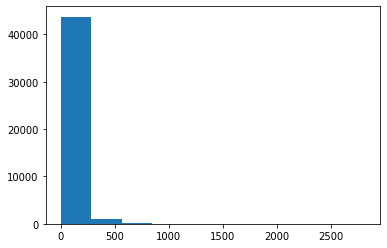

In [40]:
import matplotlib.pyplot as plt
plt.hist(data_copy.text_Upper);

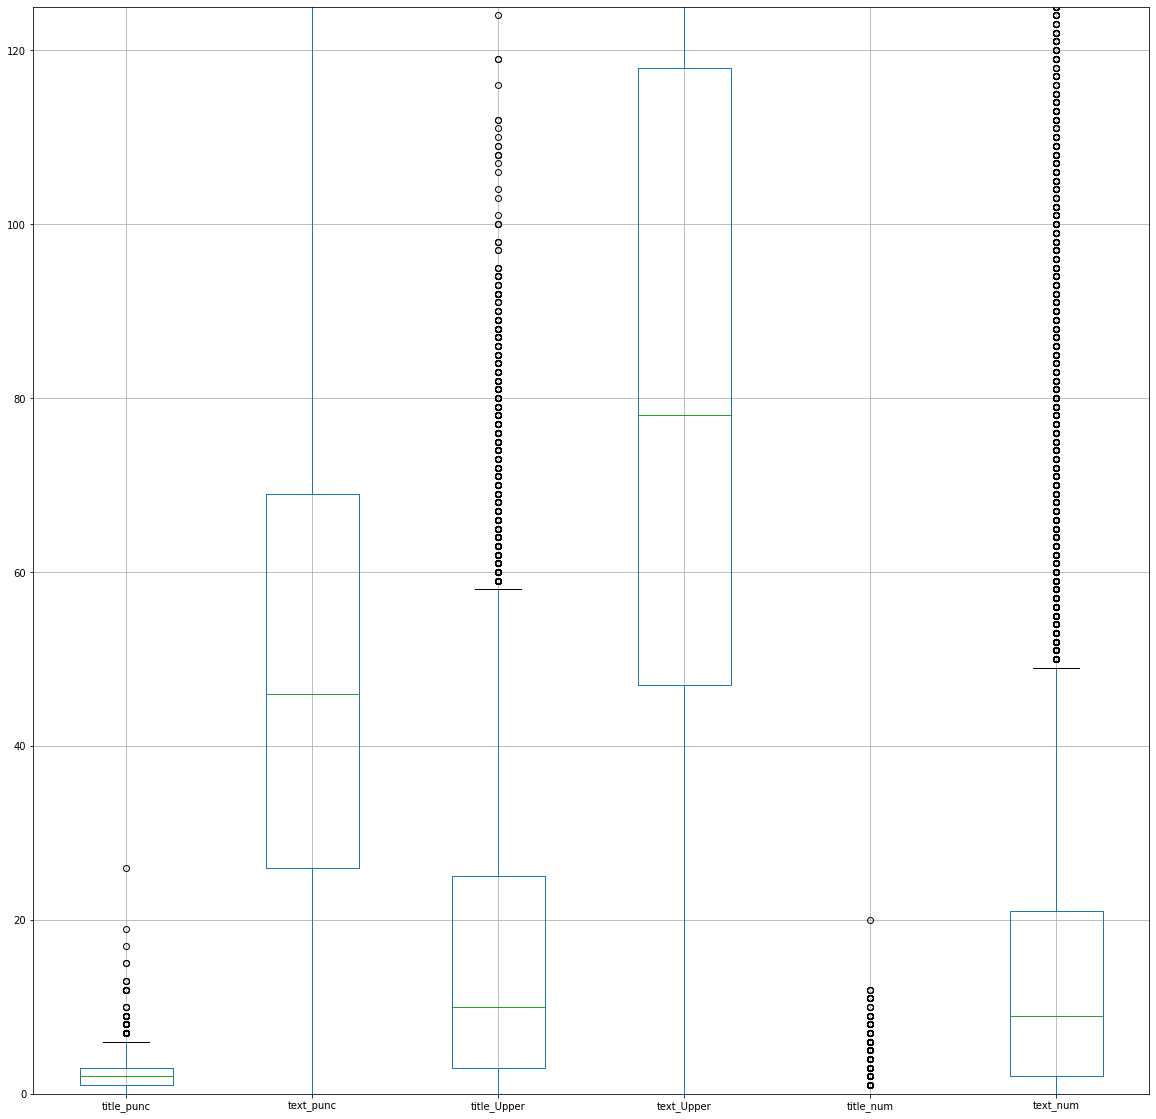

In [51]:
boxplot = data_copy.boxplot(column=['title_punc', 'text_punc', 'title_Upper','text_Upper', 'title_num', 'text_num'],figsize=(20,20))
plt.ylim(0, 125)
plt.show()

# Create pipeline

In [ ]:
x = data.drop(columns = 'score')
y = data['score']

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
preprocessor = ColumnTransformer([
    ('vectorizer_title', CountVectorizer(), 'title'),
    ('vectorizer_text', CountVectorizer(), 'text'),
    ('RobustScaler', MinMaxScaler(), ['title_punc', 'text_punc', 'title_Upper', 'text_Upper','title_num', 'text_num'])
])
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('nb', MultinomialNB())])

In [70]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.3)

In [71]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'preprocessing__vectorizer_title__ngram_range': ((1,1),(2,2),(3,3)),
    'preprocessing__vectorizer_text__ngram_range': ((1,1),(2,2),(3,3)),
    'nb__alpha': (0.1,1,2,5,10)}
grid_search = GridSearchCV(final_pipe,
                           parameters,
                           scoring = ["f1","accuracy","recall"],
                           refit="accuracy",
                           cv=5,
                           verbose = 1)

In [60]:
grid_search.fit(x_train,y_train)